In [1]:
#------------------- Change working directory to project root -------------------#
from pathlib import Path, os

cur = Path().resolve()
while not (cur / "src").is_dir():
    if cur == cur.parent: raise RuntimeError("No 'src' dir")
    cur = cur.parent

os.chdir(cur)
print(f"[INFO] Changed working directory to project root: {cur}")

[INFO] Changed working directory to project root: /home/fernando/Documents/LoRaPriv


In [2]:
# -------------------------------------- External Libraries --------------------------------------
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------------------- Local Imports ----------------------------------------
from src.core                  import LoRaPhyParams, LoRaFrameParams
from src.codec                 import LoRaCodec
from src.mod                   import LoRaModulator, plot_frame
from src.demod                 import LoRaDemodulator, plot_demodulation

In [3]:
def demo_modem(message: str, codec: LoRaCodec, mod: LoRaModulator, demod: LoRaDemodulator):
    """
    Demo: modulate + demodulate some symbols
    """
    # --- Encode a Message ---------------------------------------------------
    payload = codec.encode(message) 

    # --- Modulate --------------------------------------------------------------
    payload_sig, debug = mod.modulate(payload, debug_bundle=True, include_frame=False) 
    plot_frame(debug)                                  

    # --- Demodulate ---------------------------------------------------------
    symbols, peaks, deltas, viz_bundle = demod.demodulate(payload_sig, return_items=["symbols", "peaks", "deltas", "viz_bundle"])
    plot_demodulation(viz_bundle)
    
    print(f"[INFO] Deltas: {deltas}")
    # --- Decode the symbols -------------------------------------------------
    symbols_list = symbols.tolist() if hasattr(symbols, "tolist") else symbols
    recovered_message = codec.decode(symbols_list)
    recovered_message = recovered_message.decode("utf-8") if isinstance(recovered_message, bytes) else recovered_message

    # --- Check if everything is fine -----------------------------------------
    integrity = (recovered_message == message)
    color = "green" if integrity else "red"

    # --- Show ------- -------------------------------------------------------
    plt.figure(figsize=(20, 5))
    plt.suptitle("LoRa Modulation/Demodulation Summary", fontsize=16, fontweight="bold")

    # Symbol summary
    plt.text(0.5, 0.75, f"Modulated Symbols   : {payload[:30]}{'...' if len(payload) > 30 else ''}",
            ha="center", fontsize=13, family="monospace")
    plt.text(0.5, 0.60, f"Demodulated Symbols : {symbols.tolist()[:30]}{'...' if len(symbols) > 30 else ''}",
            ha="center", fontsize=13, family="monospace")

    # Message summary
    plt.text(0.5, 0.38, f"Original Message    : {str(message)!r}",
            ha="center", fontsize=13, family="monospace")
    plt.text(0.5, 0.23, f"Recovered Message   : {str(recovered_message)!r}",
            ha="center", fontsize=13, family="monospace")

    # Final verdict
    plt.text(0.5, 0.08,
            f"Integrity: {'✓ PASS' if integrity else '✗ FAIL'}   "
            f"  Likelihood avg: {np.round(np.mean(peaks)*100, 2)}%",
            ha="center", fontsize=14, weight="bold", color=color)

    plt.axis("off")
    plt.tight_layout()
    plt.show()


# MoDem LoRA DEMO
Este script demuestra un flujo completo de modulación y demodulación LoRa.

### Pasos principales:

1. **Codificación del mensaje**  
   Convierte un mensaje de texto en símbolos LoRa según el _spreading factor_ configurado.

2. **Modulación**  
   Transforma los símbolos en una señal I/Q lista para ser transmitida.

3. **Demodulación**  
   Recupera los símbolos originales a partir de la señal modulada, usando un demodulador compatible con CPU/GPU.

4. **Decodificación**  
   Reconstruye el mensaje original a partir de los símbolos demodulados.

5. **Verificación e inspección visual**  
   Se muestra una visualización de la señal demodulada, junto con un resumen que indica si la transmisión fue exitosa y qué tan confiable fue (likelihood).

In [4]:
# --- Notebook Configuration ------------------------------------------
modulator_backend = "numpy"    # Use "numpy" for Modulator backend as it is better suited for MIMD
demodulator_backend = "numpy"   # Use "cupy" for Demodulator backend as it is optimized for SIMD
fold_mode = "0FPA"             # Use "0FPA" to assume folding with no CFO (This is a simulation)

phy_params = LoRaPhyParams(

    spreading_factor     = 7,
    bandwidth            = 125e3,
    samples_per_chip     = 10
    )

frame_params = LoRaFrameParams(

    preamble_symbol_count = 8,
    sync_word             = 0x00,
    explicit_header       = True
    )

[WARN - PHY LoRA params] samples_per_chip > 2 is not standard. This may lead to unexpected results in some cases. (FPA and CPA folding may not work as expected)


In [5]:
codec = LoRaCodec(phy_params)

modulator = LoRaModulator(
    phy_params, 
    frame_params, 
    backend=modulator_backend
)

demodulator = LoRaDemodulator(
    phy_params,
    backend=demodulator_backend,
    fold_mode=fold_mode
)

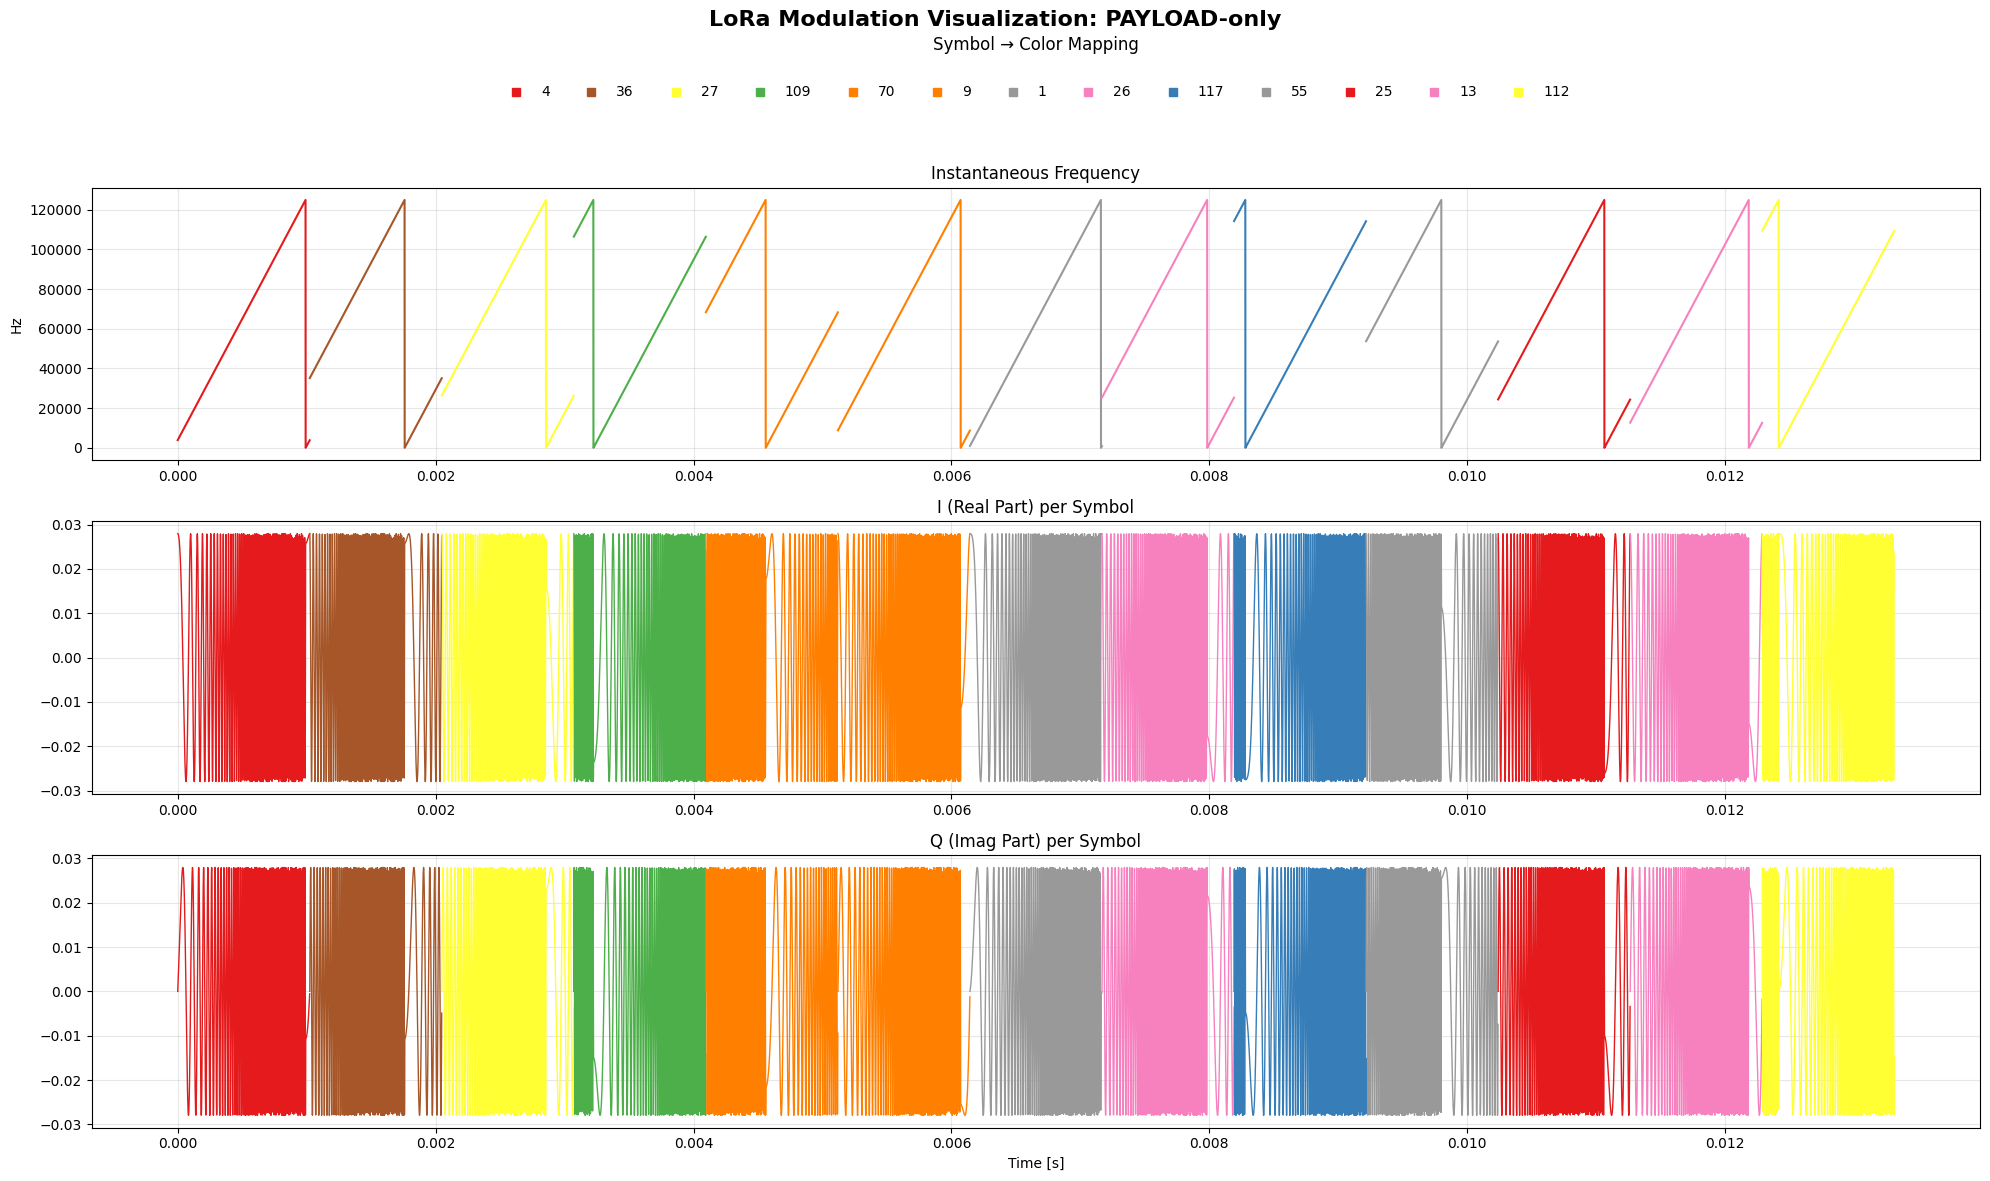

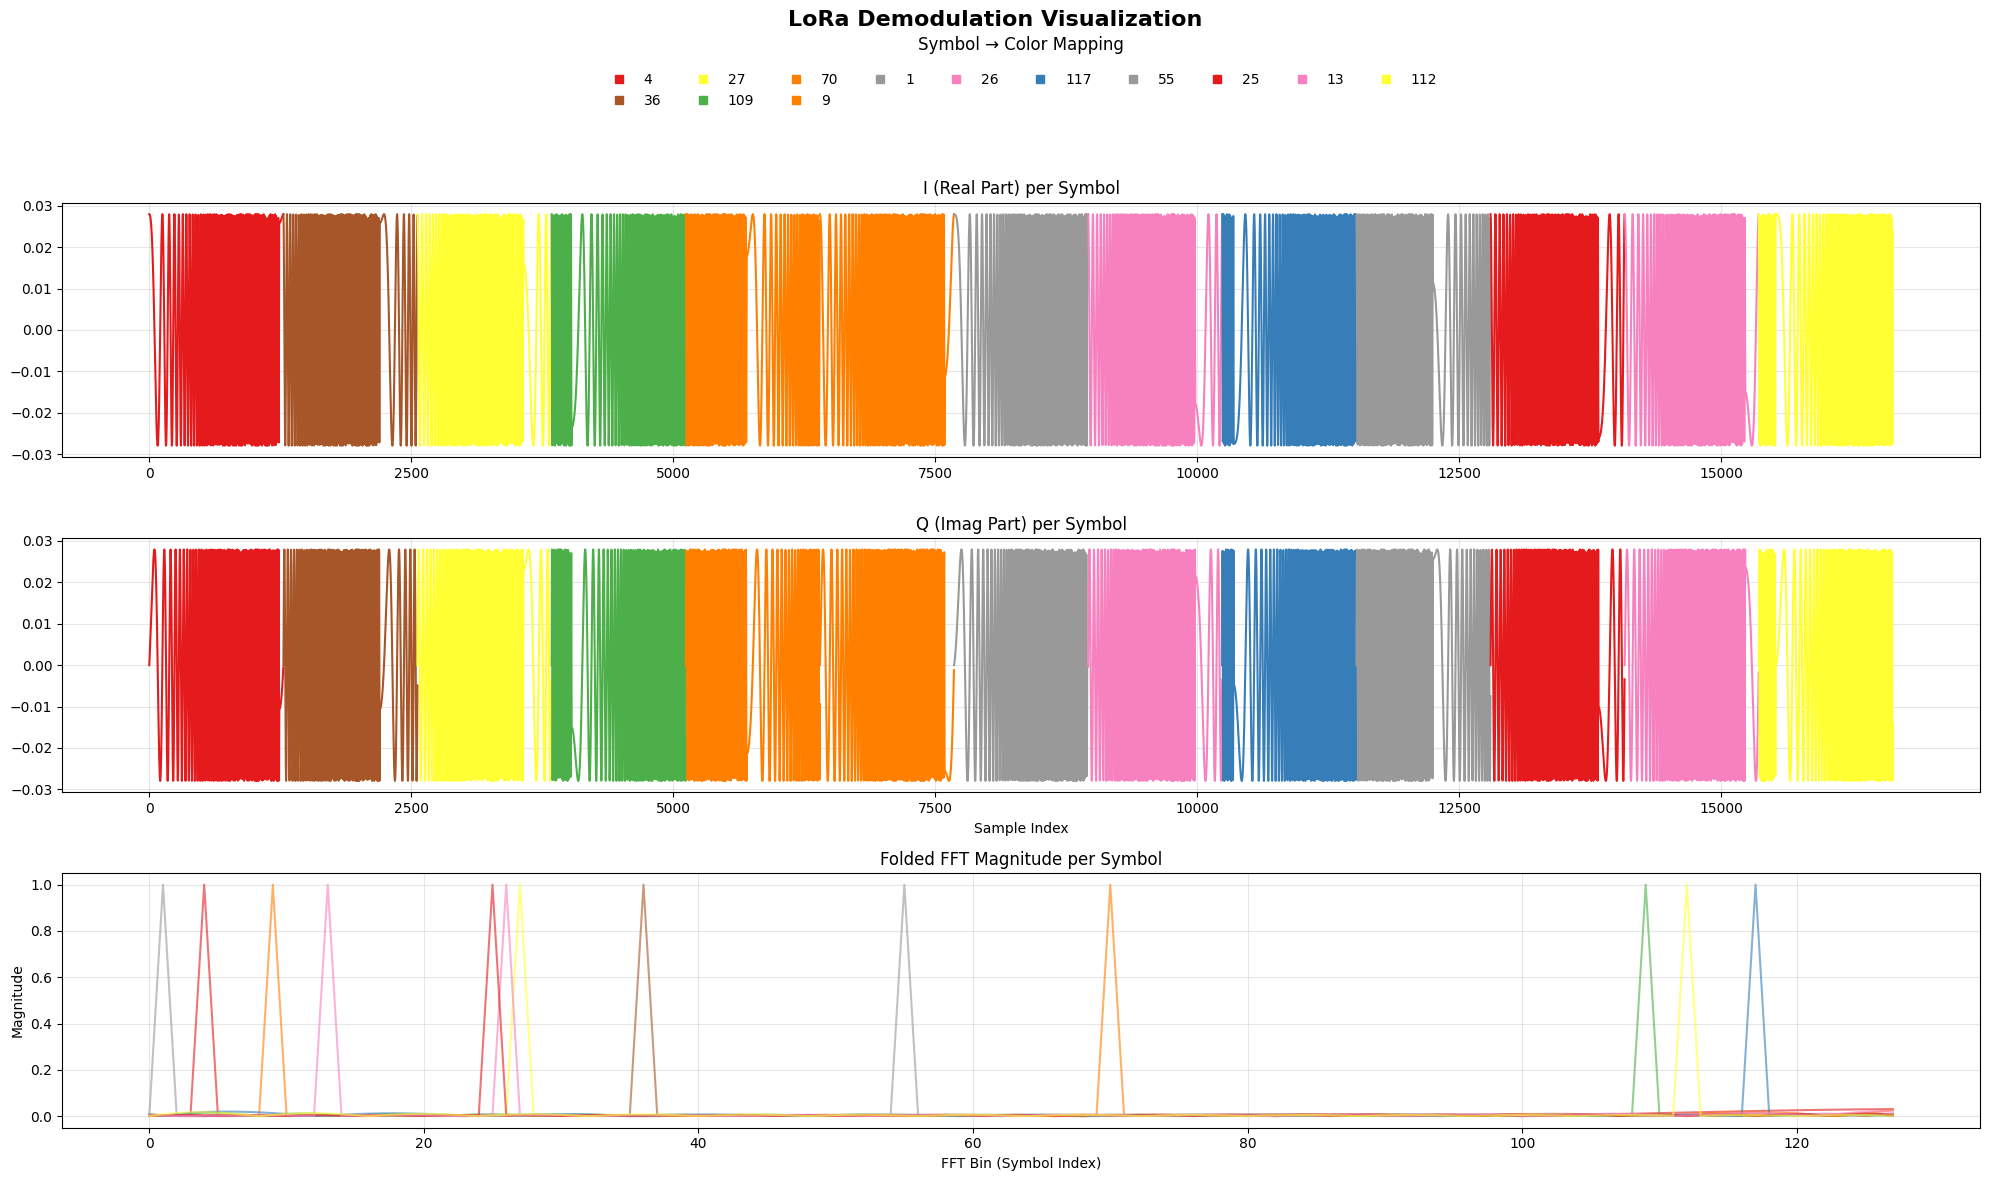

[INFO] Deltas: [-2.1284976e-08  3.4061717e-08  2.3293802e-08  5.3491981e-08
  4.9829922e-08 -3.6767844e-08  6.1652949e-09  1.3484616e-08
  4.3886573e-08  4.9943683e-08  9.1639905e-09 -5.7042350e-08
  5.0296570e-08]


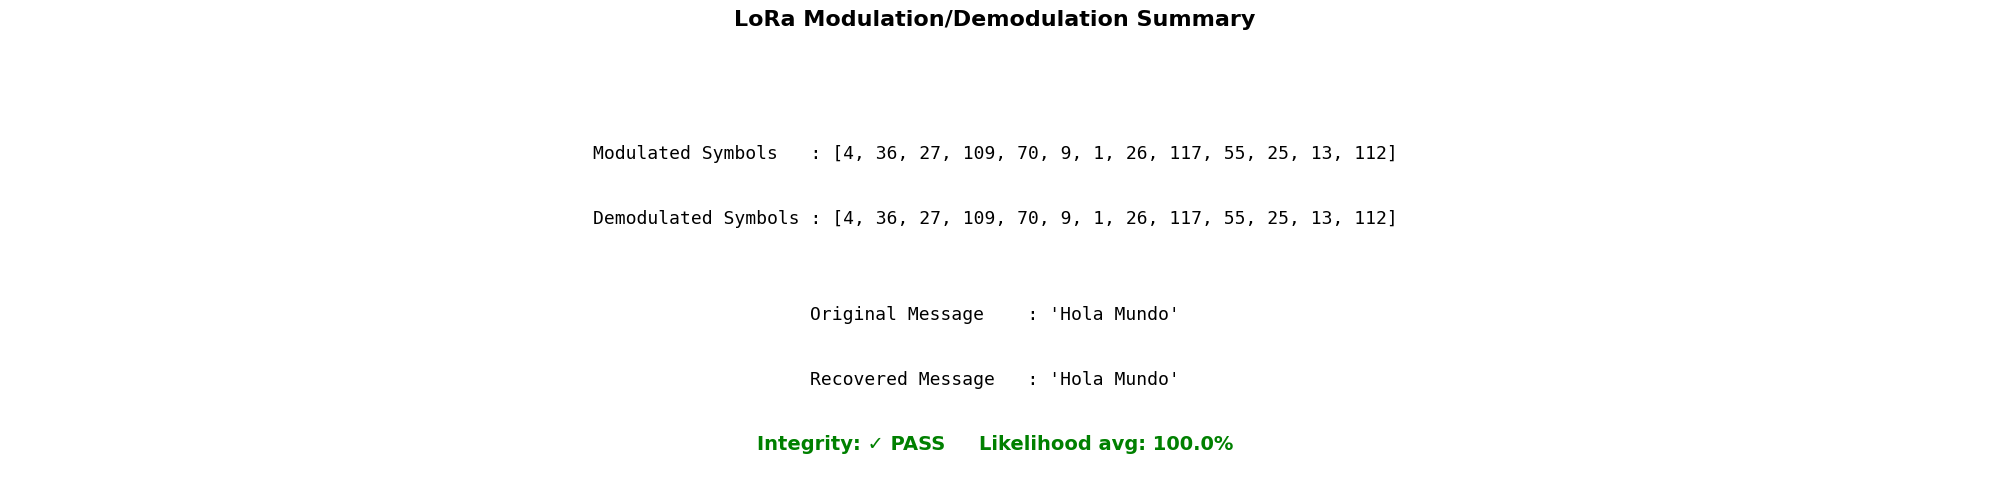

In [6]:

MESSAGE = "Hola Mundo"

demo_modem(MESSAGE, codec, modulator, demodulator)